In [1]:
from fastai.text import * 
from fastai.callbacks import *
from sklearn.model_selection import train_test_split
from pathlib import Path
import pickle as pkl

In [2]:
PATH = Path('.')
MODELS_PATH = PATH / 'models'
MODELS_PATH.mkdir(exist_ok=True)

In [3]:
import unicodedata
import pandas as pd
import re
import spacy
import json

In [4]:
def normalize_title(title):
    s = re.sub(r'[^a-zA-Z0-9ñç% ]', ' ', unicodedata.normalize('NFKD', title.lower()).encode('ascii', 'ignore').decode("utf-8"))
#    s = re.sub(r'[\d]+', "1", s)
    s = re.sub(r's |s$', ' ', s)
    s = re.sub(r' +', ' ', s)
    s = re.sub(r'(1 )+', '1 ', s)
    return re.sub(r'o |o$', 'a ', s).strip()

In [5]:
with open("main_categories.json", "r") as f:
    cats = json.load(f)

In [6]:
df = pd.read_csv(PATH / 'train.csv')
df = df[df.language == 'spanish']
#df.category = df.category.map(cats)
df.title = df.title.apply(normalize_title)
df = df[~df.title.isna() & (df.title != 'nan') & (df.title != '')]

In [41]:
df.head()

,title,label_quality,language,category
0,hidrolavadora lavor one 120 bar 1700w bomba al...,unreliable,spanish,Ferramentas e Construcao
1,placa de sonida behringer umc22,unreliable,spanish,Informatica
4,flashe led pestana luminosa falsa pestana para...,unreliable,spanish,Beleza e Cuidado Pessoal
9,gatita lunchera neoprene,unreliable,spanish,"Arte, Papelaria e Armarinho"
11,rosaria contador de billete uv mg detecta fals...,unreliable,spanish,"Agro, Industria e Comercio"


In [42]:
df.title.apply(lambda x: len(x.split(" "))).sum(axis = 0)

77099094

In [44]:
data_lm = (TextList.from_df(df, cols=['title'], processor=[SPProcessor('es', max_vocab_sz=15000, tmp_dir='lm_es_v4')])
    .split_by_rand_pct(0.1, seed=42)
    .label_for_lm()
    .databunch(bs=96, num_workers=1))

TypeError: __init__() got an unexpected keyword argument 'name'

In [32]:
data_lm.save('data_lm_v4_export.pkl')

In [59]:
data_lm = load_data('', 'data_lm_v4_export.pkl', bs=300)

In [7]:
len(data_lm.vocab.itos),len(data_lm.train_ds), len(data_lm.vocab.stoi)

(15000, 8999972, 15000)

In [6]:
data_lm.show_batch(rows=10)

idx,text
0,▁base ▁simil ▁cementa ▁30 ▁cm ▁x ▁5 ▁mm ▁xxbos ▁maquina ▁para ▁sublimar ▁estampar ▁gold ex ▁60 x 40 ▁xxbos ▁notebook ▁hp ▁pavilion ▁dv 6500 ▁special ▁edition ▁xxbos ▁maquina ▁de ▁coser ▁brother ▁industrial ▁xxbos ▁fernet ▁branca ▁menta ▁450 ▁cc ▁100 ▁x ▁caja ▁xxbos ▁oportunidad ▁notebook ▁dell ▁i 3 ▁4 gb ▁ddr 4 ▁hd ▁1 tb ▁win ▁10 ▁xxbos ▁schwarzkopf ▁fi bre ▁force ▁mascarilla ▁ fort ifica nte ▁xxbos ▁atornillador ▁taladra ▁inalambrica
1,gb ▁magic g ate ▁xxbos ▁reloj ▁invicta ▁para ▁hombre ▁2 367 9 ▁pra ▁diver ▁200 m ▁tablera ▁xxbos ▁calesita ▁4 ▁n ▁hamaca ▁2 ▁n ▁tobogan ▁6 ▁escalone ▁ 769 c ▁760 c ▁78 2 ▁xxbos ▁papel ▁bifaz ▁pai ge ▁evan ▁little ▁adventure r ▁10 ▁30 ▁5 ▁x ▁30 ▁5 ▁cm ▁xxbos ▁modular ▁rack ▁de ▁pina ▁xxbos ▁disfraz ▁toy ▁story ▁woody ▁con ▁luz ▁77 42 10 ▁4 310 ▁4 110 ▁xxbos
2,▁phone ▁hol ster ▁belt ▁xxbos ▁vinila ▁lamina ▁poster ▁60 x 90 cm ▁m 17 21 ▁arte ▁japone ▁pintura ▁ ilu ▁xxbos ▁la ▁plata ▁tablet ▁alcatel ▁pi x i 3 ▁10 ▁quadcore ▁16 gb ▁1 gb ▁5 mp ▁xxbos ▁cocina ▁orbi ▁4 ▁hornalla ▁xxbos ▁chapa ▁plastica ▁1 ▁10 ▁x ▁12 ▁25 ▁mt ▁acanalada ▁a ▁t 101 ▁xxbos ▁casita ▁infantil ▁amplia ▁oferta ▁limitada ▁xxbos ▁set ▁2 ▁madeja ▁de ▁lana ▁de ▁oveja ▁merina
3,▁27 ▁gira ▁10 x 10 cm ▁xxbos ▁tapon ▁terma ▁matera ▁cebador ▁marca ▁lumilagra ▁original ▁xxbos ▁semilla ▁mini ▁ ra ba nita ▁cherry ▁bell e ▁xxbos ▁portacosmetica ▁snoopy ▁division ▁1 ▁sn p 33 4 ▁5 ▁6 ▁7 ▁4 ▁xxbos ▁modula ▁de ▁mani pul acion ▁festa ▁hs w ▁16 ▁a ▁xxbos ▁kit ▁2 ▁cazoleta ▁delantera ▁monroe ▁axia ▁corsa ▁wagon ▁1 ▁6 ▁2010 ▁xxbos ▁2 ▁pecera ▁usada ▁equipa da ▁lista ▁para ▁usar ▁xxbos
4,▁cpu ▁original ▁amd ▁1 a 02 c 3 w 00 ▁am 3 ▁xxbos ▁pelota ▁voley ▁futbol ▁numera ▁5 ▁simil ▁cuera ▁sintetica ▁leer ▁xxbos ▁portavela ▁tarra ▁vidria ▁plateada ▁life ▁local ▁barria ▁belgrana ▁xxbos ▁inyector ▁volkswagen ▁1 ▁6 ▁1 ▁8 ▁mpi ▁iwp 04 4 ▁magneti ▁marelli ▁xxbos ▁deflector ▁ventana ▁saveira ▁trend ▁10 ▁gol ▁trend ▁13 ▁g 6 ▁coliza ▁xxbos ▁etiquetadora ▁x ▁2 ▁und ▁de ▁8 ▁digita ▁auta ▁adhesiva ▁etiqueta ▁xxbos ▁griferia ▁banera
5,▁x ▁5 ▁led ▁tri ▁fidget ▁mana ▁spinner ▁de da ▁bola ▁escritoria ▁ed ▁xxbos ▁deposita ▁agua ▁limpia ▁parabrisa ▁vw ▁pola ▁espanol ▁original ▁xxbos ▁ron ▁cacique ▁vainilla ▁electrica ▁xxbos ▁mapa ▁antigua ▁de ▁h ung ria ▁ru mania ▁y ▁yu g os la via ▁xxbos ▁encordada ▁nylon ▁guitarra ▁clasica ▁campana ▁export ▁cristal ▁xxbos ▁juega ▁de ▁bocallave ▁con ▁maletin ▁incluida ▁bremen ▁d ml 5 ▁xxbos ▁stop tech ▁126 ▁400 13 sr ▁rotor ▁frena ▁xxbos
6,▁8 ▁silla ▁de ▁chenille ▁xxbos ▁bonga ▁lc ▁xxbos ▁lunch one ra ▁calor ▁xxbos ▁herreria ▁portamaceta ▁de ▁pared ▁en ▁hierra ▁floresta ▁xxbos ▁climatizador ▁top ▁house ▁ ua ▁ 006 ▁xxbos ▁videa ▁pcie ▁asu ▁dual ▁gtx 10 60 ▁o 6 g ▁xxbos ▁pata ▁pata ▁calesita ▁formula 1 ▁bocina ▁f 1 ▁xxbos ▁camiseta ▁enmarcada ▁talle ▁xl ▁marca ▁taller ▁de ▁cuadra ▁xxbos ▁destornillador ▁plana ▁electricidad ▁1000 v ▁proskit ▁sd ▁800 ▁s 5 ▁5 ▁xxbos
7,▁antigua ▁jarra ▁casa ▁colonial ▁recuerda ▁san ▁telma ▁el ▁rep e cha ▁xxbos ▁soporte ▁tv ▁led ▁iofi ▁sp ▁24 ▁movil ▁hisense ▁24 ▁vesa ▁200 x 200 ▁xxbos ▁freezer ▁cajon ▁horizontal ▁na ▁funciona ▁xxbos ▁bulba ▁e lectroventilador ▁peugeot ▁citroen ▁xxbos ▁preservativa ▁prime ▁turba ▁x 1 ▁pack ▁xxbos ▁kit ▁bujia ▁ngk ▁y ▁cable ▁de ▁bujia ▁genoud ▁meriva ▁xxbos ▁whisky ▁escoce ▁xxbos ▁minecraft ▁ps 3 ▁digital ▁xxbos ▁manguera ▁goma ▁sin ▁tela ▁para ▁combustible ▁8
8,▁principal ▁trasera ▁motorola ▁xt 550 ▁original ▁xxbos ▁jacket ▁wallet ▁with ▁tra y ▁brown ▁brown ▁xxbos ▁raqueta ▁de ▁teni ▁sufix ▁aluminia ▁xxbos ▁torna ▁profesional ▁para ▁una ▁esculpida ▁nail ▁drill ▁roja ▁xxbos ▁kit ▁handy ▁x 2 ▁baofeng ▁bf ▁ 888 ▁originale ▁handie ▁gtia ▁fc ▁a ▁a ▁b ▁xxbos ▁star ▁war ▁mascara ▁electronica ▁stormtrooper ▁original ▁hasbra ▁xxbos ▁andador ▁bebe ▁con ▁juguete ▁musical ▁premium ▁rainbow ▁luca ▁xxbos ▁island ▁flight ▁sim ula tor ▁ps 4
9,▁libra ▁esterlina ▁plata ▁alambre ▁ronda ▁mu e ▁xxbos ▁estufa ▁salamandra ▁a ▁lena ▁doble ▁frente ▁vidria ▁xxbos ▁cabina ▁para ▁filtra ▁de ▁pi

In [60]:
config = awd_lstm_lm_config.copy()
config['qrnn'] = True
config['n_hid'] = 1550 #default 1152
config['n_layers'] = 4 #default 3

In [67]:
perplexity = Perplexity()
learn = language_model_learner(data_lm, AWD_LSTM, config=config, drop_mult=0., pretrained=False, 
                               metrics=[accuracy, perplexity])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.51E-03
Min loss divided by 10: 1.20E-02


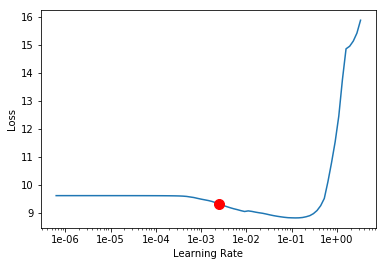

In [11]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [9]:
lr = 3e-3
lr *= learn.data.batch_size/48

In [10]:
learn.fit_one_cycle(10, lr, moms=(0.8,0.7), wd = 0.01, 
                    callbacks=[SaveModelCallback(learn, monitor='accuracy', name='best_lm_v4')])

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.555591,4.557366,0.263938,95.331993,47:02
1,4.518930,4.514627,0.262697,91.343529,47:00
2,4.403814,4.404668,0.273055,81.832230,47:51
3,4.282228,4.290837,0.285521,73.027451,47:15
4,4.170370,4.191624,0.296104,66.130043,47:51
5,4.065007,4.087585,0.307754,59.595879,48:03
6,3.939193,3.976044,0.320407,53.305889,48:01
7,3.809250,3.870514,0.333895,47.967018,47:57
8,3.697811,3.800232,0.344121,44.711582,47:27
9,3.626915,3.786598,0.346897,44.106022,47:57


Better model found at epoch 0 with accuracy value: 0.26393845677375793.
Better model found at epoch 2 with accuracy value: 0.2730553150177002.
Better model found at epoch 3 with accuracy value: 0.28552135825157166.
Better model found at epoch 4 with accuracy value: 0.2961044907569885.
Better model found at epoch 5 with accuracy value: 0.3077539801597595.
Better model found at epoch 6 with accuracy value: 0.32040703296661377.
Better model found at epoch 7 with accuracy value: 0.3338945806026459.
Better model found at epoch 8 with accuracy value: 0.3441213369369507.
Better model found at epoch 9 with accuracy value: 0.34689727425575256.


In [ ]:
%%javascript
Jupyter.notebook.session.delete();

<IPython.core.display.Javascript object>

learn.load('best_lm_v3');

In [17]:
learn.unfreeze()
wd = 0.01 
learn.fit_one_cycle(10, lr, wd=wd, moms=(0.8,0.7), 
                    callbacks=[SaveModelCallback(learn.to_fp32(), monitor='accuracy', name='best_lm_v3')])

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time
0,4.325352,4.309789,0.697576,0.302425,74.424973,47:51
1,4.054984,4.056368,0.676989,0.323011,57.764175,47:36
2,3.978574,3.977717,0.671535,0.328465,53.395039,47:43
3,3.871433,3.879084,0.661038,0.338962,48.379906,47:17
4,3.774092,3.793369,0.651632,0.348370,44.405678,47:22
5,3.677126,3.702215,0.640092,0.359908,40.536915,48:07
6,3.563842,3.608304,0.628212,0.371789,36.903263,47:05
7,3.448874,3.522034,0.615705,0.384295,33.853149,46:44
8,3.350172,3.466978,0.606776,0.393224,32.039711,47:42
9,3.278136,3.457582,0.604433,0.395567,31.740067,47:47


Better model found at epoch 0 with accuracy value: 0.3024246394634247.
Better model found at epoch 1 with accuracy value: 0.32301071286201477.
Better model found at epoch 2 with accuracy value: 0.328464537858963.
Better model found at epoch 3 with accuracy value: 0.3389618694782257.
Better model found at epoch 4 with accuracy value: 0.34836965799331665.
Better model found at epoch 5 with accuracy value: 0.3599082827568054.
Better model found at epoch 6 with accuracy value: 0.3717890679836273.
Better model found at epoch 7 with accuracy value: 0.38429465889930725.
Better model found at epoch 8 with accuracy value: 0.39322414994239807.
Better model found at epoch 9 with accuracy value: 0.39556747674942017.


In [27]:
learn.data.vocab.save(('models/v4_vocab_es' + '.pkl'))

In [26]:
learn.predict('celular moto g', 10, temperature=0.75)

'celular moto g dual sim 4 g lte nueva libre local factura a'

In [ ]:
data_lm = load_data('', 'data_lm_v4_export.pkl', bs=300)

In [23]:
learn.save_encoder('best_lm_v3_encoder')

In [8]:
df.category = df.category.map(cats)

In [83]:
df.head()

,title,label_quality,language,category
0,hidrolavadora lavor one 120 bar 1700w bomba al...,unreliable,spanish,Ferramentas e Construcao
1,placa de sonida behringer umc22,unreliable,spanish,Informatica
4,flashe led pestana luminosa falsa pestana para...,unreliable,spanish,Beleza e Cuidado Pessoal
9,gatita lunchera neoprene,unreliable,spanish,"Arte, Papelaria e Armarinho"
11,rosaria contador de billete uv mg detecta fals...,unreliable,spanish,"Agro, Industria e Comercio"


In [9]:
train, valid = train_test_split(df, test_size=0.1, stratify=df.category, random_state = 42)

In [11]:
data_class = ItemLists('', TextList.from_df(train, vocab=data_lm.vocab, cols=['title'], processor=SPProcessor.load('',tmp_dir='lm_es_v4')),
                        TextList.from_df(valid, vocab=data_lm.vocab, cols=['title'], processor=SPProcessor.load('',tmp_dir='lm_es_v4')))
data_class = data_class.label_from_df(cols=['category'])
data_class = data_class.databunch(bs=800, num_workers=1)                                     

In [12]:
data_class.save('data_class_v4_export.pkl')

In [7]:
data_class = load_data('', 'data_class_v4_export.pkl', bs=500, num_workers=1)

In [13]:
data_class.show_batch(rows=10)

text,target
▁xxbos ▁cooler ▁para ▁hp ▁g 6 ▁1 d 01 d x ▁g 6 ▁1 d 08 d x ▁g 6 ▁1 d 11 d x ▁g 6 ▁1 d 16 d x ▁g 6 ▁1 d 18 d x ▁g 6 ▁1 d 20 ca ▁g 6 ▁1 d 21 ca ▁g 6 ▁1 d 21 d x ▁g 6 ▁1 d 22 ca ▁g 6 ▁1 d 25 ca,Informatica
▁xxbos ▁bateria ▁aa ▁pb z n 2 t p ▁para ▁samsung ▁chromebook ▁3 ▁ati v ▁x e 500 t 1 c ▁30 3 c ▁x e 30 3 c 12 ▁x e 30 3 c ▁x e 500 t ▁x e 500 c ▁x e 50 3 c ▁x e 30 3 c 12 ▁x e 30 3 c 12 ▁a,Informatica
▁xxbos ▁cooler ▁para ▁hp ▁2000 ▁2 d 09 ca ▁2000 ▁2 d 10 nr ▁2000 ▁2 d 29 w m ▁2000 ▁2 d 49 w m ▁2000 ▁2 d 55 nr ▁2000 ▁2 d 37 cl ▁2000 ▁2 d 56 nr ▁2000 ▁2 d 61 nr ▁2000 ▁2 d 56,Informatica
▁xxbos ▁cooler ▁gp u ▁para ▁ cle va ▁np 8 150 ▁p 150 em ▁p 150 ▁p 570 ▁760 m ▁750 ▁p 170 ▁p 370 ▁ w 370 ▁ w 370 sk ▁np 8 150 ▁np 8 130 ▁np 8 170 ▁np 9 150 ▁6 ▁31 ▁x 720 ▁101,Informatica
▁xxbos ▁cooler ▁para ▁hp ▁envy ▁x 360 ▁15 ▁bp ▁15 m ▁bp ▁15 m ▁bp 011 d x ▁15 m ▁bp 012 d x ▁15 m ▁bp 021 d x ▁15 ▁bp 165 cl ▁15 ▁bp 14 3 cl ▁15 ▁bp 152 w m ▁15 ▁bp 194 cl ▁15,Informatica
▁xxbos ▁bateria ▁para ▁acer ▁aspire ▁e 14 ▁e 15 ▁e 5 ▁4 21 ▁e 14 ▁touch ▁e 15 ▁touch ▁e 5 ▁5 72 g ▁e 5 ▁5 72 g ▁5 93 y ▁acer ▁ext ensa ▁250 9 ▁ex 250 9 ▁25 10 ▁ex 25 10 ▁25,Informatica
▁xxbos ▁bateria ▁a 138 2 ▁para ▁macbook ▁pra ▁15 ▁inch ▁a 12 86 ▁ear ly ▁2011 ▁la te ▁2011 ▁mid ▁2012 ▁para ▁md 103 x x ▁a ▁md 104 x x ▁a ▁md 322 x x ▁a ▁md 318 x x ▁a,Informatica
▁xxbos ▁bateria ▁l 12 l 4 e 01 ▁para ▁lenova ▁ideapad ▁g 400 ▁g 405 ▁g 510 ▁g 500 ▁g 505 ▁g 510 ▁s 410 p ▁s 510 p ▁touch ▁z 710 ▁erase r ▁g 50 ▁80 ▁serie ▁l 12,Informatica
▁xxbos ▁circuita ▁integrada ▁25 x 20 cl ni g ▁ w 25 x 20 cl ni g ▁25 x 20 ▁25 x 20 cl ▁ w 25 x 20 ▁ w 25 x 20 cl ▁netbook,"Eletronicos, Audio e Video"
▁xxbos ▁bateria ▁00 h w 04 4 ▁00 h w 04 3 ▁para ▁lenova ▁thinkpad ▁yoga ▁11 e ▁serie ▁20 g 8 ▁s 03 400 ▁sb 10 j 7 899 2 ▁11 ▁25 v ▁42 wh,Informatica


In [6]:
num_trn = len(data_class.train_ds.x)
num_val = len(data_class.valid_ds.x)
num_trn, num_val, num_trn+num_val

(8999971, 999997, 9999968)

In [7]:
trn_LabelCounts = np.unique(data_class.train_ds.y.items, return_counts=True)[1]
val_LabelCounts = np.unique(data_class.valid_ds.y.items, return_counts=True)[1]
trn_LabelCounts, val_LabelCounts

(array([1712223,  241581,  181490,  106553,   87527,  172679,  212091,  362926,  316217,  529277,  163890,   10773,
        1415582,  188799,  313947,  394727,  568453,  622573,  129059,   65273,  544163,   12361,  272126,  112064,
          47957,   89510,   35713,   90437]),
 array([190247,  26842,  20165,  11839,   9725,  19187,  23566,  40325,  35135,  58809,  18210,   1197, 157287,  20978,
         34883,  43858,  63161,  69175,  14340,   7253,  60463,   1373,  30236,  12452,   5329,   9945,   3968,  10049]))

In [8]:
trn_weights = [1 - count/num_trn for count in trn_LabelCounts]
val_weights = [1 - count/num_val for count in val_LabelCounts]
trn_weights, val_weights

([0.8097523869799136,
  0.973157580174425,
  0.9798343794663338,
  0.9881607396290499,
  0.9902747464408497,
  0.9808133826208996,
  0.9764342573992738,
  0.959674758952001,
  0.9648646645639192,
  0.9411912549495993,
  0.9817899413231442,
  0.9988029961429876,
  0.8427126042961695,
  0.9790222657384118,
  0.96511688759886,
  0.9561413031219768,
  0.9368383520346899,
  0.9308249993249978,
  0.9856600649046536,
  0.9927474210750235,
  0.9395372496200266,
  0.9986265511299981,
  0.9697636803496367,
  0.9875484043226361,
  0.994671427274599,
  0.9900544123975511,
  0.9960318761027119,
  0.9899514120656611],
 [0.8097524292572877,
  0.9731579194737584,
  0.9798349395048185,
  0.9881609644828935,
  0.9902749708249124,
  0.9808129424388273,
  0.9764339293017879,
  0.9596748790246371,
  0.9648648945946838,
  0.9411908235724707,
  0.9817899453698361,
  0.9988029964089892,
  0.8427125281375845,
  0.9790219370658112,
  0.965116895350686,
  0.9561418684256053,
  0.9368388105164316,
  0.93082479247

In [9]:
len(trn_weights), len(val_weights)

(28, 28)

In [10]:
from sklearn.metrics import f1_score

@np_func
def f1(inp,targ): 
    y_pred = np.argmax(inp, axis=-1)
    return f1_score(targ, y_pred, average='weighted',  labels=np.unique(y_pred))

class WeightedLabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, weight, eps:float=0.1, reduction='mean'):
        super().__init__()
        self.weight,self.eps,self.reduction = weight,eps,reduction
        
    def forward(self, output, target):
        c = output.size()[-1]
        log_preds = F.log_softmax(output, dim=-1)
        if self.reduction=='sum': loss = -log_preds.sum()
        else:
            loss = -log_preds.sum(dim=-1)
            if self.reduction=='mean':  loss = loss.mean()
        return loss*self.eps/c + (1-self.eps) * F.nll_loss(log_preds, target, weight=self.weight, reduction=self.reduction)

In [9]:
config = awd_lstm_clas_config.copy()
config['qrnn'] = True
config['n_hid'] = 1550 #default 1152
config['n_layers'] = 4 #default 3

In [20]:
learn_c = text_classifier_learner(data_class, AWD_LSTM, pretrained=False, config=config, drop_mult=0.3)
learn_c.load_encoder('best_lm_es_v4_encoder');

In [21]:
loss_weights = torch.FloatTensor(trn_weights).cuda()
learn_c.loss_func = FlattenedLoss(WeightedLabelSmoothingCrossEntropy, weight=loss_weights)

In [22]:
learn_c.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-02
Min loss divided by 10: 5.25E-02


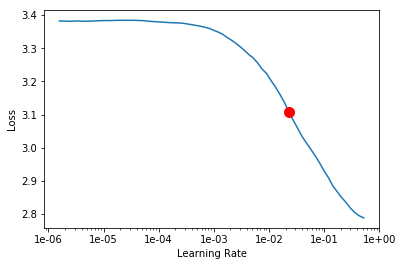

In [23]:
learn_c.lr_find()
learn_c.recorder.plot(skip_end=10, skip_start=15, suggestion=True)

In [24]:
learn_c.fit_one_cycle(2, 3e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.711065,1.181512,0.830341,20:23
1,1.680871,1.157908,0.839438,19:41


In [25]:
learn_c.show_results(rows=300)

text,target,prediction
▁xxbos ▁bateria ▁t 54 f j ▁m 5 y 0 x ▁para ▁dell ▁latitude ▁e 5 430 ▁e 64 20 ▁e 64 30 ▁e 65 20 ▁e 5 420 ▁e 65 30 ▁e 55 30 ▁e 55 20 ▁p ▁n ▁t 54 f j ▁m 5 y 0 x ▁8 858 x ▁4 y r j h ▁2 p 2 m j,Informatica,Informatica
▁xxbos ▁bateria ▁para ▁asu ▁x 5 c ▁k 50 i j ▁a 32 ▁f 82 ▁k 40 ▁k 40 i j ▁k 50 ▁k 50 ab ▁k 50 i ▁k 50 in ▁k 61 ic ▁a 32 ▁f 52 ▁l 06 90 l 6 ▁x 5 di j ▁a ▁k 50 ▁x 70 ▁x 5 a ▁07 g 016 76 18,Informatica,Informatica
▁xxbos ▁cooler ▁para ▁hp ▁g 7 ▁2 279 w m ▁g 7 ▁2 289 w m ▁g 7 ▁2 269 w m ▁g 7 ▁2 235 d x ▁g 7 ▁2 240 u ▁g 7 ▁2 250 nr ▁g 7 ▁2 296 nr ▁g 7 ▁22 34 ca ▁g 7 ▁22 46 nr ▁g 7 ▁2 298 nr ▁g 7 ▁22,Informatica,Informatica
▁xxbos ▁cooler ▁para ▁hp ▁g 6 ▁2000 ▁g 7 ▁2000 ▁g 6 ▁2 278 d x ▁g 7 ▁2 247 u ▁g 7 ▁2 240 u ▁g 7 ▁2 251 d x ▁g 7 ▁2 323 d x ▁g 7 ▁2 325 d x ▁g 7 ▁2 340 d x ▁g 7 ▁2 341 d x ▁6 831 93 ▁00,Informatica,Informatica
▁xxbos ▁bateria ▁15 ▁2 v ▁61 ▁25 wh ▁gnc ▁j 40 ▁para ▁gigabyte ▁p 34 f ▁v 5 ▁p 34 g ▁v 2 ▁v 5 ▁v 7 ▁p 34 w ▁v 3 ▁v 4 ▁v 5 ▁p 34 k ▁v 3 ▁v 5 ▁v 7 ▁p 34 w ▁v 3 ▁v 4 ▁v 5 ▁x mg ▁c 50 4 ▁ser,Informatica,Informatica
▁xxbos ▁cooler ▁para ▁acer ▁aspire ▁m 5 ▁ 481 ▁m 5 ▁ 481 pt ▁m 5 ▁ 481 pt g ▁m 5 ▁ 481 t ▁m 5 ▁ 481 t g ▁m 5 ▁ 481 g ▁m 3 ▁ 481 ▁x 48 3 g ▁serie ▁ab 08 005 h x 07 q b 00 ▁z 09 ▁fan,Informatica,Informatica
▁xxbos ▁bateria ▁g 5 m 10 ▁para ▁dell ▁latitude ▁e 5 450 ▁e 5 550 ▁e 55 70 ▁type ▁7 v 69 y ▁6 mt 4 t ▁8 v 5 g x ▁79 v r k ▁tx f 9 m ▁ w y j c 2 ▁0 w y j c 2 ▁08 v 5 g x,Informatica,Informatica
▁xxbos ▁bateria ▁aa ▁pb x n 8 ar ▁para ▁samsung ▁900 x 4 ▁900 x 46 ▁900 x 4 b ▁900 x 4 c ▁900 x 4 d ▁np 900 x 4 ▁np 900 x 4 c ▁np 900 x 4 d ▁900 x 4 b ▁a 01 de ▁900 x 4 c ▁a 01 fr ▁90,Informatica,Informatica
▁xxbos ▁bateria ▁64 wh ▁li ▁poly mer ▁nm v 5 c ▁para ▁dell ▁xp ▁15 z ▁l 511 z ▁l 511 x ▁58 34 el ▁750 2 el ▁para ▁p ▁n ▁0 ht r 7 ▁0 ht r 7 ▁0 nm v 5 c ▁ 075 w y z ▁75 w y 2 ▁ 075 w,Informatica,Informatica
▁xxbos ▁bateria ▁para ▁acer ▁aspire ▁v 3 ▁v 3 ▁ 471 g ▁v 3 ▁ 551 g ▁v 3 ▁5 71 g ▁v 3 ▁ 731 ▁v 3 ▁ 771 ▁v 3 ▁77 2 g ▁e 1 ▁ 531 ▁e 1 ▁ 731 ▁aspire ▁5 750 ▁5 750 g ▁5 742 ▁5 742 g ▁ 574,Informatica,Informatica


In [29]:
learn_c.freeze_to(-2)
learn_c.fit_one_cycle(2, 3e-2, wd=0.01, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.234450,0.956305,0.902456,20:20
1,1.130108,0.924792,0.912437,21:18


In [31]:
learn_c.save('/data/anime/ml/classifier_es_v4')

In [32]:
lr = 3e-2
wd = 0.01
learn_c.freeze_to(-3)
learn_c.fit_one_cycle(2, slice(lr/(2.6**4),lr), wd=wd, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.022582,0.881816,0.922672,25:19
1,0.956349,0.848356,0.930427,25:42


In [33]:
learn_c.save('/data/anime/ml/classifier_es_v4_2')

In [12]:
lr = 3e-2
wd = 0.01
learn_c = text_classifier_learner(data_class, AWD_LSTM, pretrained=False, config=config, drop_mult=0.3)
learn_c.load('/data/anime/ml/classifier_es_v4_2')
learn_c.unfreeze()
learn_c.fit_one_cycle(1, slice(lr/10/(2.6**4),lr/10), wd=wd, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.324505,0.241602,0.933161,43:30


In [13]:
learn_c.save('/data/anime/ml/classifier_es_v4_3')
learn_c.export('/data/anime/ml/classifier_es_v4_3_export')

In [14]:
learn_c.fit_one_cycle(1, slice(lr/10/(2.6**4),lr/10), wd=wd, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.291118,0.232400,0.935370,43:28


In [15]:
learn_c.save('/data/anime/ml/classifier_es_v4_3')
learn_c.export('/data/anime/ml/classifier_es_v4_3_export')

In [11]:
learn_c = text_classifier_learner(data_class, AWD_LSTM, pretrained=False, config=config, drop_mult=0.3)
learn_c.load('/data/anime/ml/classifier_es_v4_2')
learn_c.export('/data/anime/ml/classifier_es_v4_2_export')

In [1]:
df

NameError: name 'df' is not defined